Import libraries

In [129]:
# Import required libraries

import pandas as pd
import os
import requests
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np

%matplotlib inline


In [112]:
# Load the environment variables from the .env file

load_dotenv()


True

Tickers list

In [113]:
#Create list of tickers for the bond portfolio

tickers = ["BLV", "BND", "EDV", "VCLT", "VGLT"]


#Review bond portfolio tickers

tickers


['BLV', 'BND', 'EDV', 'VCLT', 'VGLT']

API key

In [114]:
# Set the variables for the Alpaca API and secret keys

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca tradeapi.REST object

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    

Alpaca API call

In [115]:
# Set timeframe to 1D 

timeframe = "1D"


# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day

start_date = pd.Timestamp("2020-01-02", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-01-02", tz="America/New_York").isoformat()


In [116]:
# Use the Alpaca get_barset function to get current closing prices the bond portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame


bonds_prices = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df


# Review the bond tickers Alpaca DataFrame

bonds_prices.head()


BLV                                         BND  \
                             open      high       low   close   volume   open   
time                                                                            
2020-01-02 00:00:00-05:00  100.67  101.2500  100.6700  100.87  2428578  83.98   
2020-01-03 00:00:00-05:00  101.28  102.0000  101.2300  101.99  1201205  84.18   
2020-01-06 00:00:00-05:00  102.10  102.3900  101.3000  101.43   687743  84.30   
2020-01-07 00:00:00-05:00  101.28  101.3900  100.9500  100.99   643372  84.20   
2020-01-08 00:00:00-05:00  101.09  101.3976  100.4304  100.63   571043  84.13   

                                                           ...    VCLT  \
                              high    low  close   volume  ...    open   
time                                                       ...           
2020-01-02 00:00:00-05:00  84.1100  83.93  83.98  4221018  ...  101.80   
2020-01-03 00:00:00-05:00  84.2900  84.10  84.26  5432336  ...  102.05   
2020-01-06 00:00:00-05:00  84.3099  84.11  84.16  3845484  ...  102.64   
2020-01-07 00:00:00-05:00  84.2000  84.07  84.07  3115250  ...  101.69   
2020-01-08 00:00:00-05:00  84.1971  83.90  83.97  3637969  ...  101.52   

                                                             VGLT          \
                              high     low   close  volume   open    high   
time                                                                        
2020-01-02 00:00:00-05:00  102.150  101.48  101.68  461013  83.75  84.310   
2020-01-03 00:00:00-05:00  102.455  101.97  102.40  537791  84.78  85.310   
2020-01-06 00:00:00-05:00  102.700  101.75  101.83  573593  85.65  85.650   
2020-01-07 00:00:00-05:00  101.820  101.32  101.32  175668  84.76  84.907   
2020-01-08 00:00:00-05:00  101.820  100.98  101.11  322433  84.61  84.808   

                                                       
                               low    close    volume  
time                                                   
2020-01-02 00:00:00-05:00  83.7500  84.0132  478428.0  
2020-01-03 00:00:00-05:00  84.5600  85.2600  268534.0  
2020-01-06 00:00:00-05:00  84.7229  84.8382  259873.0  
2020-01-07 00:00:00-05:00  84.4100  84.4400  288386.0  
2020-01-08 00:00:00-05:00  83.6200  83.8800  279854.0  

[5 rows x 25 columns]

Monte Carlo 10 year simulation

In [117]:
# Configure the Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split evenly across bonds.
# Run 1000 samples.

MC_bonds_10 = MCSimulation(
    portfolio_data = bonds_prices,
    weights = [.2, .2, .2, .2, .2],
    num_simulation = 1000,
    num_trading_days = 252*10)


# Review the simulation input data

MC_bonds_10.portfolio_data.head()

BLV                                       \
                             open      high       low   close   volume   
time                                                                     
2020-01-02 00:00:00-05:00  100.67  101.2500  100.6700  100.87  2428578   
2020-01-03 00:00:00-05:00  101.28  102.0000  101.2300  101.99  1201205   
2020-01-06 00:00:00-05:00  102.10  102.3900  101.3000  101.43   687743   
2020-01-07 00:00:00-05:00  101.28  101.3900  100.9500  100.99   643372   
2020-01-08 00:00:00-05:00  101.09  101.3976  100.4304  100.63   571043   

                                          BND                         ...  \
                          daily_return   open     high    low  close  ...   
time                                                                  ...   
2020-01-02 00:00:00-05:00          NaN  83.98  84.1100  83.93  83.98  ...   
2020-01-03 00:00:00-05:00     0.011103  84.18  84.2900  84.10  84.26  ...   
2020-01-06 00:00:00-05:00    -0.005491  84.30  84.3099  84.11  84.16  ...   
2020-01-07 00:00:00-05:00    -0.004338  84.20  84.2000  84.07  84.07  ...   
2020-01-08 00:00:00-05:00    -0.003565  84.13  84.1971  83.90  83.97  ...   

                             VCLT                                VGLT          \
                              low   close  volume daily_return   open    high   
time                                                                            
2020-01-02 00:00:00-05:00  101.48  101.68  461013          NaN  83.75  84.310   
2020-01-03 00:00:00-05:00  101.97  102.40  537791     0.007081  84.78  85.310   
2020-01-06 00:00:00-05:00  101.75  101.83  573593    -0.005566  85.65  85.650   
2020-01-07 00:00:00-05:00  101.32  101.32  175668    -0.005008  84.76  84.907   
2020-01-08 00:00:00-05:00  100.98  101.11  322433    -0.002073  84.61  84.808   

                                                                    
                               low    close    volume daily_return  
time                                                                
2020-01-02 00:00:00-05:00  83.7500  84.0132  478428.0          NaN  
2020-01-03 00:00:00-05:00  84.5600  85.2600  268534.0     0.014841  
2020-01-06 00:00:00-05:00  84.7229  84.8382  259873.0    -0.004947  
2020-01-07 00:00:00-05:00  84.4100  84.4400  288386.0    -0.004694  
2020-01-08 00:00:00-05:00  83.6200  83.8800  279854.0    -0.006632  

[5 rows x 30 columns]

In [118]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns

MC_bonds_10.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991104,0.991359,0.995559,1.003807,0.992873,0.996848,0.989240,0.997164,1.000319,1.001964,...,0.996368,1.015185,0.999893,1.008318,1.004412,1.014557,1.003930,0.998308,1.003790,0.989892
2,0.986875,0.991057,0.991814,1.004049,0.995375,0.999890,0.989671,0.998766,0.998954,1.003921,...,0.990587,1.014801,1.005898,1.013670,0.986283,1.020938,1.013238,1.003968,1.013780,0.995731
3,0.986765,0.986090,0.992002,0.996985,0.988385,0.993912,0.980306,0.993004,1.000424,1.014873,...,0.989813,1.019848,1.006853,1.008775,0.991479,1.018712,1.009018,1.006484,1.009743,1.001534
4,0.991603,0.984824,0.997897,1.003216,0.985933,0.992469,0.978006,0.990085,0.999225,1.013833,...,0.984297,1.023530,1.008147,0.999411,0.994735,1.021690,1.019648,0.996064,1.015725,1.006778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.299253,2.330147,3.665205,2.331065,3.393945,2.987527,3.374632,4.664980,4.545729,5.856981,...,2.481426,3.272001,4.097261,3.660371,3.174818,2.741344,3.664639,2.746025,3.493391,3.516700
2517,3.272579,2.317187,3.708583,2.325682,3.396061,2.976558,3.391179,4.665098,4.543617,5.918495,...,2.471348,3.233171,4.101745,3.671806,3.169075,2.783060,3.707805,2.712682,3.483217,3.552192
2518,3.294073,2.327470,3.694779,2.316787,3.421839,2.959115,3.415101,4.703835,4.525228,5.914070,...,2.439036,3.230833,4.130230,3.671826,3.196080,2.805097,3.690098,2.700068,3.486436,3.548103
2519,3.279944,2.323381,3.665807,2.302475,3.418865,2.983225,3.436208,4.725977,4.519928,5.937155,...,2.427710,3.239863,4.130223,3.671472,3.187716,2.808552,3.695727,2.714050,3.471843,3.554516


Monte Carlo 10 year visualizations & stats

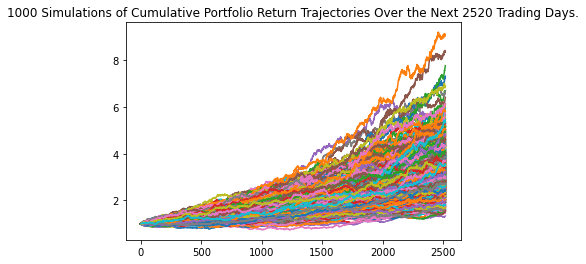

In [125]:
# Plot the 10 year MC simulation for bonds

MC_bonds_10_line_plot = MC_bonds_10.plot_simulation()


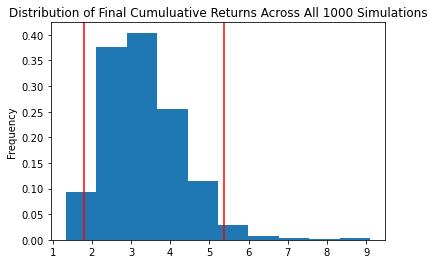

In [126]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram

MC_bonds_10_bar_plot = MC_bonds_10.plot_distribution()


In [127]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable

MC_bonds_10_table = MC_bonds_10.summarize_cumulative_return()


# Review the 10-year Monte Carlo summary statistics

print(MC_bonds_10_table)


count           1000.000000
mean               3.317687
std                0.961815
min                1.333836
25%                2.633766
50%                3.207598
75%                3.858772
max                9.102927
95% CI Lower       1.802100
95% CI Upper       5.383104
Name: 2520, dtype: float64


Monte Carlo 10 year 95% confidence interval

In [144]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the bond portfolio

ci_lower_10_cumulative_return = round(MC_bonds_10_table[8] * 10000,2)
ci_upper_10_cumulative_return = round(MC_bonds_10_table[9] * 10000,2)


# Print the result of your calculations

print(f"There is a 95% chance that the bond portfolio will end up within the range of ${ci_lower_10_cumulative_return} and ${ci_upper_10_cumulative_return} in 10 years.")


There is a 95% chance that the bond portfolio will end up within the range of $18021.0 and $53831.04 in 10 years.


Monte Carlo 30 year simulation

In [122]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split evenly across bonds.
# Run 1000 samples.

MC_bonds_30 = MCSimulation(
    portfolio_data = bonds_prices,
    weights = [.2, .2, .2, .2, .2],
    num_simulation = 1000,
    num_trading_days = 252*30)


# Review the simulation input data

MC_bonds_30.portfolio_data.head()


BLV                                       \
                             open      high       low   close   volume   
time                                                                     
2020-01-02 00:00:00-05:00  100.67  101.2500  100.6700  100.87  2428578   
2020-01-03 00:00:00-05:00  101.28  102.0000  101.2300  101.99  1201205   
2020-01-06 00:00:00-05:00  102.10  102.3900  101.3000  101.43   687743   
2020-01-07 00:00:00-05:00  101.28  101.3900  100.9500  100.99   643372   
2020-01-08 00:00:00-05:00  101.09  101.3976  100.4304  100.63   571043   

                                          BND                         ...  \
                          daily_return   open     high    low  close  ...   
time                                                                  ...   
2020-01-02 00:00:00-05:00          NaN  83.98  84.1100  83.93  83.98  ...   
2020-01-03 00:00:00-05:00     0.011103  84.18  84.2900  84.10  84.26  ...   
2020-01-06 00:00:00-05:00    -0.005491  84.30  84.3099  84.11  84.16  ...   
2020-01-07 00:00:00-05:00    -0.004338  84.20  84.2000  84.07  84.07  ...   
2020-01-08 00:00:00-05:00    -0.003565  84.13  84.1971  83.90  83.97  ...   

                             VCLT                                VGLT          \
                              low   close  volume daily_return   open    high   
time                                                                            
2020-01-02 00:00:00-05:00  101.48  101.68  461013          NaN  83.75  84.310   
2020-01-03 00:00:00-05:00  101.97  102.40  537791     0.007081  84.78  85.310   
2020-01-06 00:00:00-05:00  101.75  101.83  573593    -0.005566  85.65  85.650   
2020-01-07 00:00:00-05:00  101.32  101.32  175668    -0.005008  84.76  84.907   
2020-01-08 00:00:00-05:00  100.98  101.11  322433    -0.002073  84.61  84.808   

                                                                    
                               low    close    volume daily_return  
time                                                                
2020-01-02 00:00:00-05:00  83.7500  84.0132  478428.0          NaN  
2020-01-03 00:00:00-05:00  84.5600  85.2600  268534.0     0.014841  
2020-01-06 00:00:00-05:00  84.7229  84.8382  259873.0    -0.004947  
2020-01-07 00:00:00-05:00  84.4100  84.4400  288386.0    -0.004694  
2020-01-08 00:00:00-05:00  83.6200  83.8800  279854.0    -0.006632  

[5 rows x 30 columns]

In [128]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns

MC_bonds_30.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.987237,1.012016,0.998108,0.993481,0.996034,1.006778,0.993771,0.993067,1.004533,1.003058,...,1.007202,1.001698,0.992762,1.001561,0.999375,0.992801,1.010420,1.006113,0.997646,1.006033
2,0.983602,1.007293,0.998345,0.992247,0.994992,1.013263,0.990620,0.994974,1.004433,1.002069,...,1.008107,1.004854,0.991681,0.991418,0.997035,0.996870,1.010380,1.008250,0.995311,1.009969
3,0.981609,1.010719,0.995855,0.987914,0.991246,1.017473,0.988490,0.997994,1.001545,0.995852,...,1.012558,1.004735,0.991440,0.991161,0.995788,0.991876,1.014287,1.001501,1.000285,1.010088
4,0.984099,1.020666,0.992271,0.980733,0.986999,1.026770,0.989243,1.003353,1.006086,0.995391,...,1.017188,1.004200,0.990117,0.991650,0.992300,0.982690,1.002963,1.003800,0.992631,1.011962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,23.376461,45.245318,19.732632,42.222638,42.968118,53.799650,22.761919,20.312973,31.030720,34.729579,...,30.484040,28.091990,35.377893,39.479718,18.260966,36.638157,59.999861,32.580903,55.001145,43.393965
7557,23.358590,45.255995,19.616687,42.642622,42.575903,53.475348,22.551335,20.319156,31.032758,34.515185,...,30.524586,28.250629,35.593062,39.997663,18.413761,36.247958,60.113137,32.769176,55.074293,43.723807
7558,23.315924,45.392582,19.388863,42.362743,42.943545,53.912161,22.372013,20.492300,30.832040,34.631841,...,30.527151,28.365606,35.787229,39.531688,18.517261,36.273745,59.974390,32.544372,54.286984,43.150361
7559,23.259816,45.356668,19.294465,42.144144,42.775928,53.896792,22.368305,20.260610,30.995869,34.616202,...,30.090113,28.570747,35.641747,40.057490,18.524891,36.186240,59.579263,32.601860,54.072922,43.141822


Monte Carlo 30 year visualizations & stats

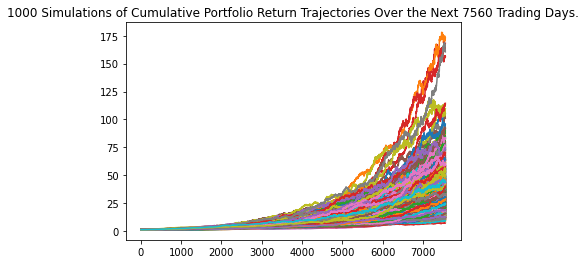

In [138]:
# Plot the 30 year MC simulation for bonds

MC_bonds_30_line_plot = MC_bonds_30.plot_simulation()

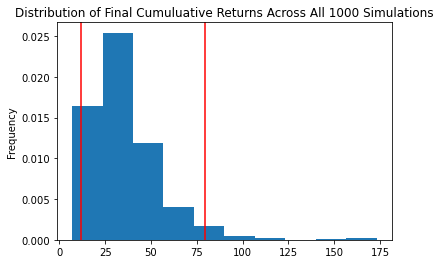

In [139]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram

MC_bonds_30_bar_plot = MC_bonds_30.plot_distribution()


In [140]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable

MC_bonds_30_table = MC_bonds_30.summarize_cumulative_return()


# Review the 10-year Monte Carlo summary statistics

print(MC_bonds_30_table)

count           1000.000000
mean              35.752185
std               18.904545
min                6.996153
25%               23.190962
50%               32.277231
75%               43.216823
max              173.086727
95% CI Lower      12.026333
95% CI Upper      79.414626
Name: 7560, dtype: float64


Monte Carlo 30 year 95% confidence interval

In [142]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the bond portfolio

ci_lower_30_cumulative_return = round(MC_bonds_30_table[8] * 10000,2)
ci_upper_30_cumulative_return = round(MC_bonds_30_table[9] * 10000,2)


# Print the result of your calculations

print(f"There is a 95% chance that the bond portfolio will end up within the range of ${ci_lower_30_cumulative_return} and ${ci_upper_30_cumulative_return} in thirty years.")

There is a 95% chance that the bond portfolio will end up within the range of $120263.33 and $794146.26 in thirty years.


Closing price dataframe

In [119]:

# Create an empty DataFrame to populate the closing prices on the bonds

bonds_closing_prices = pd.DataFrame()


# Use for-loop to pull the tickers' closing prices and populate the bonds_closing_prices DataFrame

for ticker in tickers:
    bonds_closing_prices[ticker] = bonds_prices[ticker]["close"] 


# Review DataFrame

bonds_closing_prices


,BLV,BND,EDV,VCLT,VGLT
time,,,,,
2020-01-02 00:00:00-05:00,100.87,83.980,131.69,101.68,84.0132
2020-01-03 00:00:00-05:00,101.99,84.260,134.27,102.40,85.2600
2020-01-06 00:00:00-05:00,101.43,84.160,133.56,101.83,84.8382
2020-01-07 00:00:00-05:00,100.99,84.070,132.65,101.32,84.4400
2020-01-08 00:00:00-05:00,100.63,83.970,131.63,101.11,83.8800
...,...,...,...,...,...
2020-12-24 00:00:00-05:00,109.30,88.005,151.81,110.71,95.5900
2020-12-28 00:00:00-05:00,109.37,87.980,152.00,110.76,95.6200
2020-12-29 00:00:00-05:00,109.50,88.020,151.81,110.77,95.5100


Calculate aggregate daily and annual returns

In [120]:
# Calculate the bonds portfolio aggregate daily returns

bonds_portfolio_returns = bonds_closing_prices.sum(axis=1).pct_change().dropna()


# Review the first 5 rows of the aggregate daily returns

bonds_portfolio_returns.head()


time
2020-01-03 00:00:00-05:00    0.011841
2020-01-06 00:00:00-05:00   -0.004648
2020-01-07 00:00:00-05:00   -0.004642
2020-01-08 00:00:00-05:00   -0.004469
2020-01-09 00:00:00-05:00    0.003701
dtype: float64

In [132]:
# Calculate the annual average return data for the for bond portfolios
# Use 252 as the number of trading days in the year

bonds_portfolio_avg_returns = bonds_portfolio_returns.mean() * 252


# Review the annual average returns for the bond portfolio

bonds_portfolio_avg_returns


0.15817173291677522

Calculate standard deviation and annual standard deviation

In [121]:
# Calculate the bonds portfolio standard deviation

bonds_portfolio_std = bonds_portfolio_returns.std()


# Review the standard devations

bonds_portfolio_std


0.020902525838938424

In [135]:
# Calculate the annualized standard deviation (252 trading days) of the bond portfolio

bonds_portfolio_std_annualized = (bonds_portfolio_std * np.sqrt(252))


# Review the annualized std for the bond portfolio

bonds_portfolio_std_annualized


0.3318173108575969

Calculation Sharpe ratio

In [137]:
# Calculate the annualized Sharpe Ratios for the bond portfolio

bonds_portfolio_sharpe_ratio = bonds_portfolio_avg_returns / bonds_portfolio_std_annualized


# Review the Sharpe Ratio for the bonds

bonds_portfolio_sharpe_ratio


0.4766831860217696